In [1]:
import numpy
import numpy as np
from joblib import dump, load
import scipy.stats
import matplotlib.pyplot as plt

import mpld3
mpld3.enable_notebook()
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,3)

In [2]:
x = numpy.load('./data/x.npy')
y = numpy.load('./data/y.npy')

In [3]:
from ipyleaflet import Map, Heatmap

def ipyleaflet_heatmap_per_class(x, y, center=(0, 0), zoom=5, colors=['blue', 'red', 'yellow', 'orange']):
    all_classes = np.unique(y)
    m = Map(center=center, zoom=zoom)

    for i in all_classes:
        heatmap = Heatmap(
            locations=x[y==i].tolist(),
            radius=5,
            gradient={0.0: colors[i], 1.0: colors[i]},
            min_opacity=1,
        )

        m.add_layer(heatmap)
    return m

In [4]:
m = ipyleaflet_heatmap_per_class(x, y, center=(53, -2), zoom=5.5)
display(m)

Map(center=[53, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [5]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle
from sklearn.utils import shuffle

def ipyleaflet_scatterplot_per_class(x, y, center=(0, 0), zoom=5, proportion=1.0,
                                     colors=['blue', 'red', 'yellow', 'orange'],
                                     m=None):
    if m is None:
        m = Map(center=center, zoom=zoom)
    if proportion < 1.0:
        n_samples = int(x.shape[0]*proportion)
        x, y = shuffle(x, y)
        x = x[:n_samples]
        y = y[:n_samples]

    for sample_x, sample_y in zip(x.tolist(), y.tolist()):
        circle = Circle()
        circle.location = sample_x
        circle.radius = 100
        circle.color = colors[sample_y]
        circle.fill_color = colors[sample_y]

        m.add_layer(circle)
    return m

m = ipyleaflet_scatterplot_per_class(x, y, center=(53, -2), zoom=5.5, proportion=0.2)
display(m)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Map(center=[53, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

In [6]:
lon_local_grid = numpy.linspace(-2.70, -2.45, 100)
lat_local_grid = numpy.linspace(51.3, 51.55, 100)
lat_local, lon_local = numpy.meshgrid(lat_local_grid, lon_local_grid)

In [7]:
local_idx = (numpy.sqrt((x[:, 0] - 51.4545) ** 2 + (x[:, 1] + 2.5879) ** 2) <= 0.1)  

In [8]:
y[local_idx] = x[local_idx,0] > 51.45

In [9]:
bristol_center = (51.4545, -2.5879)
m = ipyleaflet_scatterplot_per_class(x[local_idx], y[local_idx], center=bristol_center, zoom=10.5, proportion=1.0)
display(m)

Map(center=[51.4545, -2.5879], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [10]:
x_local = x[local_idx, :]
y_local = y[local_idx]

In [11]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [12]:
#mdl = SVC(probability=True)
#mdl = LogisticRegression()
mdl = DecisionTreeClassifier()
mdl.fit(x[local_idx], y[local_idx])
dump(mdl, './local_mdl.joblib')
predicted_class_local = mdl.predict(x_local)
print('Training accuracy = {:0.3f}'.format(np.mean(predicted_class_local == y_local)))
print(np.unique(predicted_class_local, return_counts=True))

Training accuracy = 1.000
(array([0, 1]), array([25, 50]))


In [13]:
np.unique(y_local, return_counts=True)

(array([0, 1]), array([25, 50]))

In [14]:
#mdl = load('./local_mdl.joblib')

In [15]:
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

(array([6000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

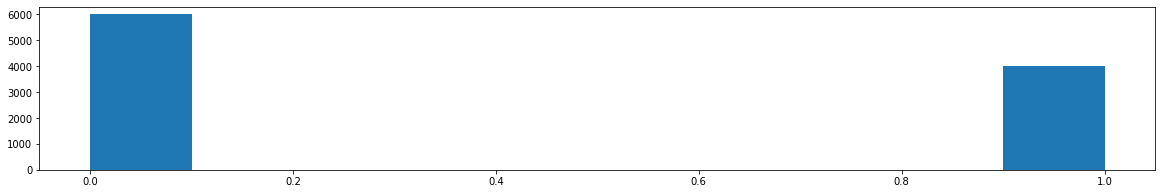

In [16]:
p_local = mdl.predict_proba(numpy.hstack([lat_local.reshape(-1, 1), 
                                         lon_local.reshape(-1, 1)]))[:, 1].reshape(lat_local.shape[0],
                                                                                   lon_local.shape[0])

fig, ax = plt.subplots(1)
ax.hist(p_local.flatten())

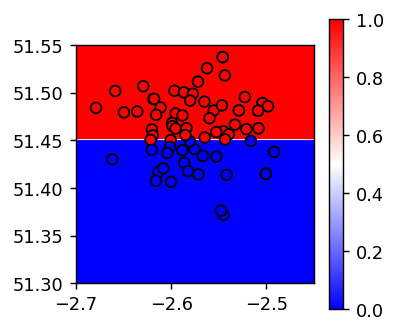

In [17]:
plt.figure(dpi=128, figsize=(3, 3))
plt.imshow(p_local.transpose(), origin='lower', #cmap='viridis',
                         extent=[-2.70, -2.45, 51.3, 51.55],
          cmap='bwr')#, vmin=0, vmax=1)
plt.scatter(x[local_idx,1], x[local_idx,0], c=y[local_idx], edgecolors='k', cmap='bwr')
plt.colorbar()

In [18]:
def mpl_scatter_contourf(clf, lat_grid, lon_grid, x, y, xlim=None, ylim=None,
                         isolines=np.linspace(0,1,10)):
    probabilities = clf.predict_proba(numpy.hstack([lat_grid.reshape(-1, 1), 
                                                    lon_grid.reshape(-1, 1)]))[:, 1].reshape(lat_grid.shape[0], 
                                                                                             lon_grid.shape[0])

    fig, ax = plt.subplots(1, figsize=(12, 9))
    cs = ax.contourf(lat_grid,  lon_grid, probabilities, isolines, alpha=0.8, cmap='bwr')
    ax.scatter(x[:,0], x[:,1], c=y, edgecolors='k', cmap='bwr')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    return fig, ax, cs

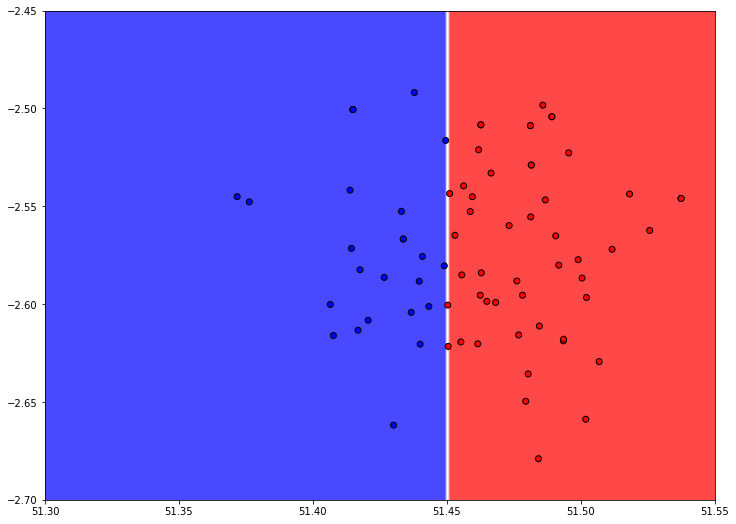

In [19]:
fig, ax, cs = mpl_scatter_contourf(mdl, lat_local, lon_local, x[local_idx], y[local_idx])
xlim = ax.get_xlim()
ylim = ax.get_ylim()

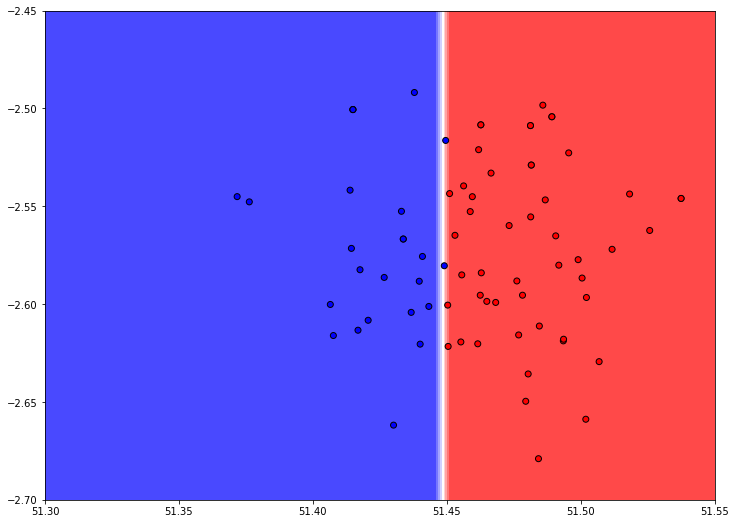

In [20]:
lon_all_grid = numpy.linspace(-3, -2, 100)
lat_all_grid = numpy.linspace(51.3, 51.9, 100)
lat_all, lon_all = numpy.meshgrid(lat_all_grid, lon_all_grid)

fig, ax, cs = mpl_scatter_contourf(mdl, lat_all, lon_all, x[local_idx], y[local_idx], xlim=xlim, ylim=ylim)

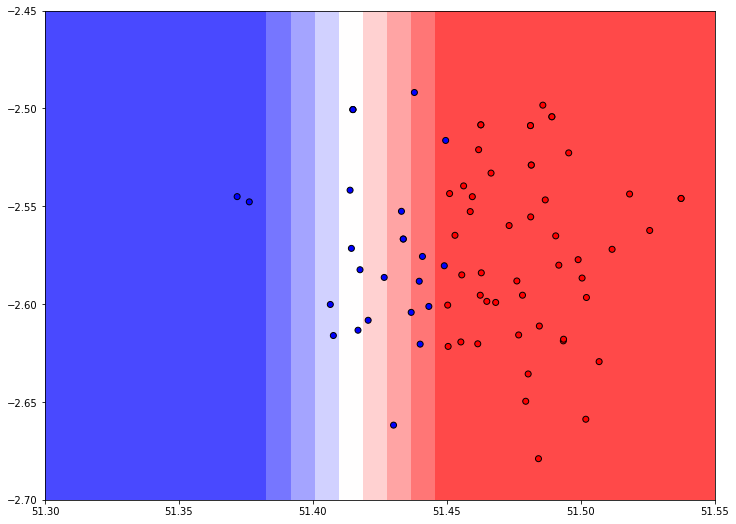

In [21]:
lon_all_grid = numpy.linspace(-6, 2, 100)
lat_all_grid = numpy.linspace(50, 58, 100)
lat_all, lon_all = numpy.meshgrid(lat_all_grid, lon_all_grid)

fig, ax, cs = mpl_scatter_contourf(mdl, lat_all, lon_all, x[local_idx], y[local_idx], xlim=xlim, ylim=ylim)

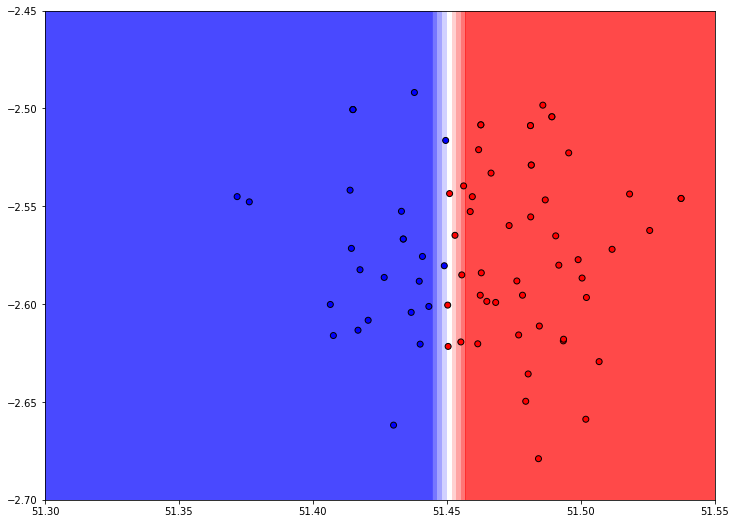

In [22]:
lon_all_grid = numpy.linspace(-6, 2, 500)
lat_all_grid = numpy.linspace(50, 58, 500)
lat_all, lon_all = numpy.meshgrid(lat_all_grid, lon_all_grid)

fig, ax, cs = mpl_scatter_contourf(mdl, lat_all, lon_all, x[local_idx], y[local_idx], xlim=xlim, ylim=ylim)

In [23]:
import ipyleaflet
from branca.colormap import linear


regions = {
    "type": "FeatureCollection",
    "features":[]
}


contour_list = []
for collection in cs.collections:
    contour_list.append([])
    paths_list = collection.get_paths()
    for path in paths_list:
        contour_list[-1].append(np.flip(path.vertices).tolist())

colors = {str(i): 1 - i/(len(contour_list)) for i in range(len(isolines) - 1)}

# TODO It seems that polygons use the longitude first and latitude second

for i, polygon_list in enumerate(contour_list):
    for polygon in polygon_list:
        regions["features"].append({
                "type":"Feature",
                "id":str(i),
                "properties":{"name":"contours"},
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [polygon]
                }
            })

layer = ipyleaflet.Choropleth(
    geo_data=regions,
    choro_data=colors,
    colormap=linear.RdBu_05,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5'})

m = Map(center=bristol_center, zoom=11)
m.add_layer(layer)
m = ipyleaflet_scatterplot_per_class(x[local_idx], y[local_idx], proportion=1.0, m=m)

from ipyleaflet import Map, LegendControl

legend_colors = {}
for i in range(len(isolines)-1):
    legend_colors["{:0.1f}-{:0.1f}".format(isolines[i], isolines[i+1])] = linear.RdBu_05(1 - i/(len(isolines)-1))
    
legend = LegendControl(legend_colors, name="Prob. C1", position="topright")
m.add_control(legend)

m

Map(center=[51.4545, -2.5879], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [24]:
from sklearn.mixture import GaussianMixture

x_local = x[local_idx, :]
y_local = y[local_idx]
x_back = x[~local_idx, :]
y_back = y[~local_idx]

local_gmm = GaussianMixture(n_components=4, covariance_type='spherical')
local_gmm.fit(x_local)
back_gmm = GaussianMixture(n_components=32, covariance_type='spherical')
back_gmm.fit(x_back)

GaussianMixture(covariance_type='spherical', n_components=32)

In [25]:
pi = numpy.array([numpy.sum(local_idx), numpy.sum(~local_idx)])
pi = pi / numpy.sum(pi)

local_d = np.exp(local_gmm.score_samples(numpy.hstack([lat_all.reshape(-1, 1), lon_all.reshape(-1, 1)])))
back_d =  np.exp(back_gmm.score_samples(numpy.hstack([lat_all.reshape(-1, 1), lon_all.reshape(-1, 1)])))

p_back = (pi[1] * back_d / (pi[1] * back_d + pi[0] * local_d)).reshape(lat_all.shape[0], lon_all.shape[0])
p_local = 1 - p_back

(-2.7, -2.45)

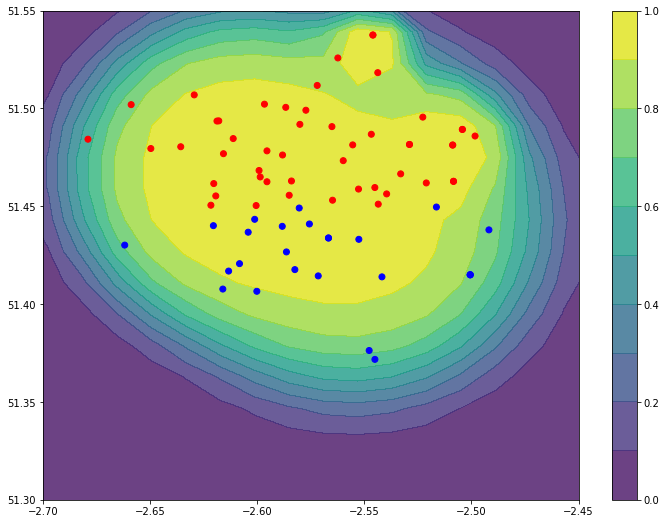

In [26]:
import mpld3
mpld3.enable_notebook()
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#isolines = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, figsize=(12, 9))
cs = ax.contourf(lon_all, lat_all,  p_local, isolines, alpha=0.8)
ax.scatter(x[local_idx,1], x[local_idx,0], c=y[local_idx], cmap='bwr')
fig.colorbar(cs, ax=ax)
ax.set_ylim(xlim)
ax.set_xlim(ylim)

In [27]:
import ipyleaflet
from branca.colormap import linear


regions = {
    "type": "FeatureCollection",
    "features":[]
}


contour_list = []
for collection in cs.collections:
    contour_list.append([])
    paths_list = collection.get_paths()
    for path in paths_list:
        contour_list[-1].append(path.vertices.tolist())

colors = {str(i): i/(len(contour_list)) for i in range(len(isolines) - 1)}

# TODO It seems that polygons use the longitude first and latitude second

for i, polygon_list in enumerate(contour_list):
    for polygon in polygon_list:
        regions["features"].append({
                "type":"Feature",
                "id":str(i),
                "properties":{"name":"contours"},
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [polygon]
                }
            })

layer = ipyleaflet.Choropleth(
    geo_data=regions,
    choro_data=colors,
    colormap=linear.viridis,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5'})

m = Map(center=bristol_center, zoom=11)
m.add_layer(layer)
m = ipyleaflet_scatterplot_per_class(x[local_idx], y[local_idx], proportion=1.0, m=m)

from ipyleaflet import Map, LegendControl

legend_colors = {}
for i in range(len(isolines)-1):
    legend_colors["{:0.1f}-{:0.1f}".format(isolines[i], isolines[i+1])] = linear.viridis(i/(len(isolines)-1))
    
legend = LegendControl(legend_colors, name="Prob. local", position="topright")
m.add_control(legend)

m

Map(center=[51.4545, -2.5879], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

# Probability of class 1 and local

In [28]:
lon_all_grid = numpy.linspace(-6, 2, 500)
lat_all_grid = numpy.linspace(50, 58, 500)
lat_all, lon_all = numpy.meshgrid(lat_all_grid, lon_all_grid)

prob_per_class = mdl.predict_proba(numpy.hstack([lat_all.reshape(-1, 1), 
                                                lon_all.reshape(-1, 1)]))

p1 = prob_per_class[:, 1].reshape(lat_all_grid.shape[0], lon_all_grid.shape[0])
p0 = prob_per_class[:, 0].reshape(lat_all_grid.shape[0], lon_all_grid.shape[0])

p1_not_back = p1 * p_local
p0_not_back = p0 * p_local

(-2.7, -2.45)

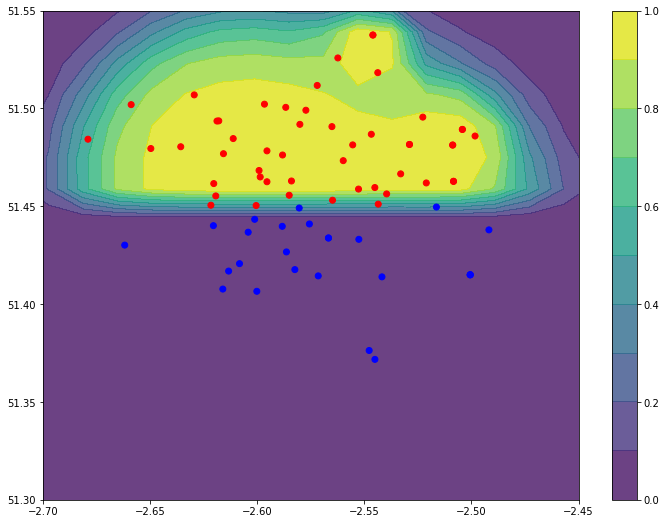

In [29]:
import mpld3
mpld3.enable_notebook()
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#isolines = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, figsize=(12, 9))
cs = ax.contourf(lon_all, lat_all,  p1_not_back, isolines, alpha=0.8)
ax.scatter(x[local_idx,1], x[local_idx,0], c=y[local_idx], cmap='bwr')
fig.colorbar(cs, ax=ax)
ax.set_ylim(xlim)
ax.set_xlim(ylim)

(-2.7, -2.45)

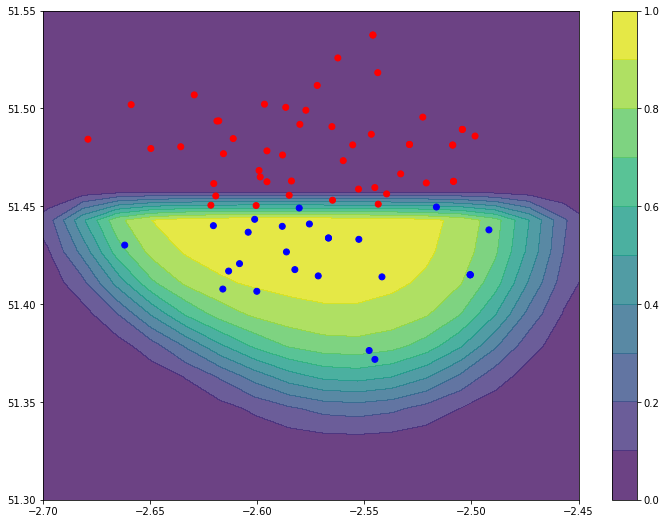

In [30]:
import mpld3
mpld3.enable_notebook()
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#isolines = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, figsize=(12, 9))
cs = ax.contourf(lon_all, lat_all,  p0_not_back, isolines, alpha=0.8)
ax.scatter(x[local_idx,1], x[local_idx,0], c=y[local_idx], cmap='bwr')
fig.colorbar(cs, ax=ax)
ax.set_ylim(xlim)
ax.set_xlim(ylim)

(51.3, 51.55)

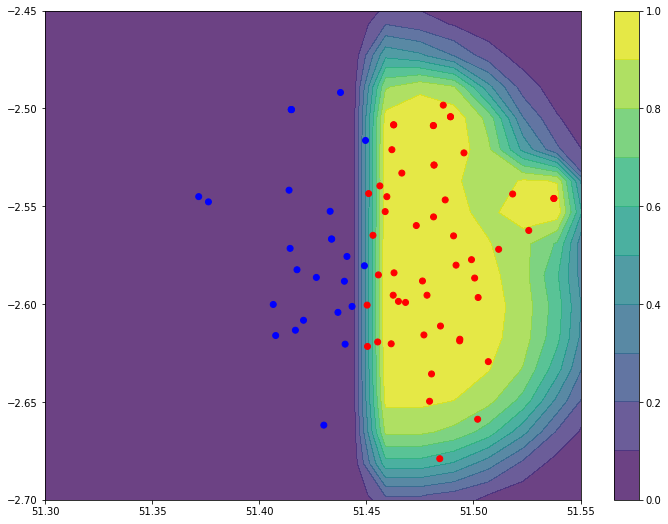

In [31]:
import mpld3
mpld3.enable_notebook()
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#isolines = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, figsize=(12, 9))
cs = ax.contourf(lat_all, lon_all,  p1_not_back, isolines, alpha=0.8)
ax.scatter(x[local_idx,0], x[local_idx,1], c=y[local_idx], cmap='bwr')
fig.colorbar(cs, ax=ax)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

In [32]:
import ipyleaflet
from branca.colormap import linear


regions = {
    "type": "FeatureCollection",
    "features":[]
}


contour_list = []
for collection in cs.collections:
    contour_list.append([])
    paths_list = collection.get_paths()
    for path in paths_list:
        contour_list[-1].append(np.flip(path.vertices).tolist())

colors = {str(i): i/(len(contour_list)) for i in range(len(isolines) - 1)}

# TODO It seems that polygons use the longitude first and latitude second

for i, polygon_list in enumerate(contour_list):
    for polygon in polygon_list:
        regions["features"].append({
                "type":"Feature",
                "id":str(i),
                "properties":{"name":"contours"},
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [polygon]
                }
            })

layer = ipyleaflet.Choropleth(
    geo_data=regions,
    choro_data=colors,
    colormap=linear.Reds_05,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5'})

m = Map(center=bristol_center, zoom=11)
m.add_layer(layer)
m = ipyleaflet_scatterplot_per_class(x[local_idx], y[local_idx], proportion=1.0, m=m)

from ipyleaflet import Map, LegendControl

legend_colors = {}
for i in range(len(isolines)-1):
    legend_colors["{:0.1f}-{:0.1f}".format(isolines[i], isolines[i+1])] = linear.Reds_05(i/(len(isolines)-1))
    
legend = LegendControl(legend_colors, name="Prob. C1", position="topright")
m.add_control(legend)

m

Map(center=[51.4545, -2.5879], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

(51.3, 51.55)

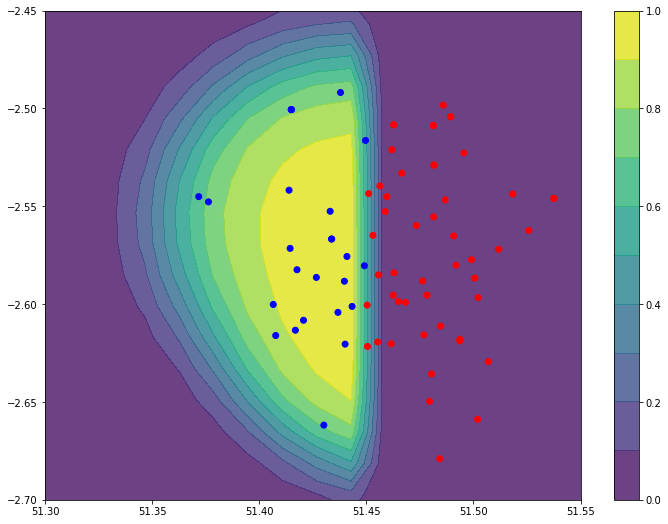

In [33]:
import mpld3
mpld3.enable_notebook()
isolines = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#isolines = np.linspace(0, 1, 100)
fig, ax = plt.subplots(1, figsize=(12, 9))
cs = ax.contourf(lat_all, lon_all,  p0_not_back, isolines, alpha=0.8)
ax.scatter(x[local_idx,0], x[local_idx,1], c=y[local_idx], cmap='bwr')
fig.colorbar(cs, ax=ax)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

In [34]:
import ipyleaflet
from branca.colormap import linear


regions = {
    "type": "FeatureCollection",
    "features":[]
}


contour_list = []
for collection in cs.collections:
    contour_list.append([])
    paths_list = collection.get_paths()
    for path in paths_list:
        contour_list[-1].append(np.flip(path.vertices).tolist())

colors = {str(i): i/(len(contour_list)) for i in range(len(isolines) - 1)}

# TODO It seems that polygons use the longitude first and latitude second

for i, polygon_list in enumerate(contour_list):
    for polygon in polygon_list:
        regions["features"].append({
                "type":"Feature",
                "id":str(i),
                "properties":{"name":"contours"},
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [polygon]
                }
            })

layer = ipyleaflet.Choropleth(
    geo_data=regions,
    choro_data=colors,
    colormap=linear.Blues_05,
    border_color='black',
    style={'fillOpacity': 0.5, 'dashArray': '5, 5'})

m = Map(center=bristol_center, zoom=11)
m.add_layer(layer)
m = ipyleaflet_scatterplot_per_class(x[local_idx], y[local_idx], proportion=1.0, m=m)

from ipyleaflet import Map, LegendControl

legend_colors = {}
for i in range(len(isolines)-1):
    legend_colors["{:0.1f}-{:0.1f}".format(isolines[i], isolines[i+1])] = linear.Blues_05(i/(len(isolines)-1))
    
legend = LegendControl(legend_colors, name="Prob. C1", position="topright")
m.add_control(legend)

m

Map(center=[51.4545, -2.5879], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…